# Supply Trend 

This is a very useful example combining functionality from our *Vessel*, *Port*, *Voyages*, *Market Rates* and *Historical Tonnage List* APIs. The aim is to plot a supply trend with superimposed predicted market rates for getting a more hollistic insight of the market behaviour during the range of interest from a specific load port and vessel class.

## Setup

Install the Signal Ocean SDK:

Import required libraries/APIs:

In [3]:
import pandas as pd
from datetime import datetime, date, timedelta, time

from signal_ocean import PortAPI, VesselClassAPI, PortFilter, VesselClassFilter, MarketRatesAPI, Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI
from signal_ocean.historical_tonnage_list import VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass

Fill in your personal SignalOcean API subscription key and open a connection:

In [4]:
signal_ocean_api_key = '9b91b6f5f26848c89e4b37f6e31c7a80' #replace with your subscription key
connection = Connection(signal_ocean_api_key)

Instantiate connections for all imported APIs:

In [5]:
port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
voyages_api = VoyagesAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
mr_api = MarketRatesAPI(connection)

## Parametrization

In order to plot a supply trend superimposed with the predicted market rates, we need to specify the following parameters: 

In [6]:
today = datetime.utcnow().date()

# specify parameters of interest #
vessel_class = 'Aframax'
load_port = 'Ceyhan'
days_back = 90                  
max_eta = 10                     
    
push_type = [PushType.PUSHED_POSS, PushType.PUSHED]
market_deployment = [MarketDeployment.RELET, MarketDeployment.SPOT]
commercial_status = [CommercialStatus.AVAILABLE, CommercialStatus.ON_SUBS, CommercialStatus.FAILED, CommercialStatus.CANCELLED]
trade = VesselSubclass.DIRTY
ais_since = 5

route_description = 'Afra - Med'
# ------------------------------ #

start_date = today - timedelta(days=days_back)
end_date = today

For more information, the user can refer to the respective documentation in the <a href="https://signaloceansdk.github.io/SignalSDK/historical_tonnage_list/" target="_blank">HTL</a> and  <a href="https://signaloceansdk.github.io/SignalSDK/market_rates/" target="_blank">Market Rates</a> API sections.

## Filter Vessels

In [7]:
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like=vessel_class))[0] 
port = port_api.get_ports(PortFilter(name_like=load_port))[0]

In [8]:
vessel_filter = VesselFilter(
    push_types=push_type,
    market_deployments=market_deployment,
    commercial_statuses=commercial_status,
    vessel_subclass=trade,
    latest_ais_since=ais_since
)

## Apply filters and extract tonnage list

In [9]:
htl = htl_api.get_historical_tonnage_list(
    loading_port=port,
    vessel_class=vessel_class,
    laycan_end_in_days=max_eta,
    start_date=start_date,
    end_date=end_date,
    vessel_filter=vessel_filter 
)

htl_for_supply_trend = htl.to_data_frame()
htl_for_supply_trend

name vessel_class ice_class  \
date                      imo                                                
2021-06-09 00:00:00+00:00 9337406         Banda Sea      Aframax       NaN   
                          9370848     Anafi Warrior      Aframax       NaN   
                          9389100            Myrtos      Aframax       NaN   
                          9384992         Guanabara      Aframax       NaN   
                          9379612      Fos Da Vinci      Aframax       NaN   
...                                             ...          ...       ...   
2021-03-11 00:00:00+00:00 9304825      Seamaster IV      Aframax       NaN   
                          9334739              Olib      Aframax        1C   
                          9416551            Alatau      Aframax       NaN   
                          9422536  Dubai Attraction      Aframax       NaN   
                          9276573  Minerva Eleonora      Aframax        1C   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-06-09 00:00:00+00:00 9337406        2007      105576          237.71   
                          9370848        2009      107593          243.80   
                          9389100        2009      106969          243.80   
                          9384992        2007      106045          240.50   
                          9379612        2009      115878          249.90   
...                                       ...         ...             ...   
2021-03-11 00:00:00+00:00 9304825        2006      109266          243.00   
                          9334739        2009      108433          246.00   
                          9416551        2009      115896          248.96   
                          9422536        2011      115459          250.00   
                          9276573        2004      103622          244.00   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-06-09 00:00:00+00:00 9337406               42    Dirty   
                          9370848               42    Dirty   
                          9389100               42    Dirty   
                          9384992               42    Dirty   
                          9379612               44    Dirty   
...                                            ...      ...   
2021-03-11 00:00:00+00:00 9304825               42    Dirty   
                          9334739               48    Dirty   
                          9416551               44    Dirty   
                          9422536               44    Dirty   
                          9276573               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-06-09 00:00:00+00:00 9337406                            Spot   
                          9370848                            Spot   
                          9389100                            Spot   
                          9384992                           Relet   
                          9379612                            Spot   
...                                                           ...   
2021-03-11 00:00:00+00:00 9304825                            Spot   
                          9334739                            Spot   
                          9416551                            Spot   
                          9422536                            Spot   
                          9276573                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-06-09 00:00:00+00:00 9337406                  Pushed  ...   
                          9370848                  Pushed  ...   
                          9389100               

## Market Rates

In [12]:
def return_selected_route(vessel_class, route_description):
    vessel_routes = mr_api.get_routes(vessel_class_id=vessel_class.id)
    for i,v in enumerate(vessel_routes):
        if vessel_routes[i].description == route_description:
            break
    return vessel_routes[i]

In [13]:
mr_route = return_selected_route(vessel_class, route_description)
market_rates = mr_api.get_market_rates(start_date, route_id=mr_route.id, vessel_class_id=vessel_class.id, end_date=end_date)
market_rates = pd.DataFrame([vars(vr) for vr in market_rates])  # question: match mr datapoints with supply_trend dp's?
market_rates['rate_date'] = pd.to_datetime(market_rates['rate_date'])
market_rates.set_index('rate_date', inplace=True) 
market_rates

,route_id,rate_value,unit,vessel_class_id
rate_date,,,,
2021-03-11,R1,115.0,WS,86
2021-03-12,R1,115.0,WS,86
2021-03-13,R1,115.0,WS,86
2021-03-14,R1,115.0,WS,86
2021-03-15,R1,125.0,WS,86
...,...,...,...,...
2021-06-05,R1,90.0,WS,86
2021-06-06,R1,90.0,WS,86
2021-06-07,R1,90.0,WS,86


## Plot: supply trend and market rates

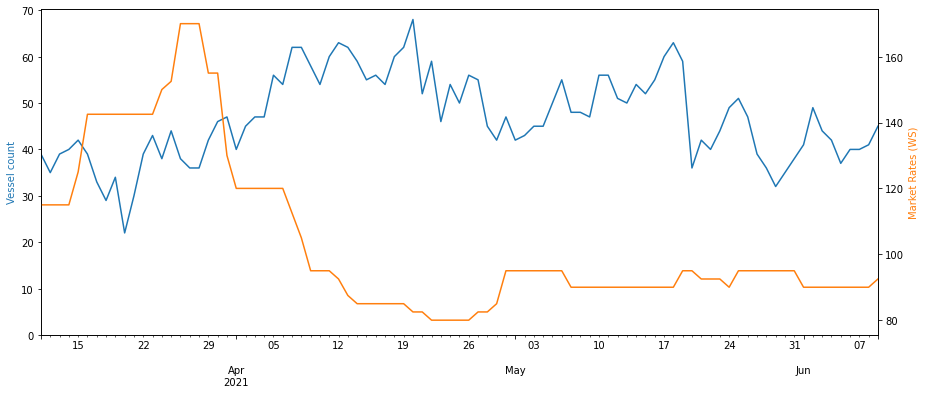

In [14]:
fig, axs = plt.subplots(figsize=(15,6))

# Left axis (Supply plot)
supply_plot = supply_trend.plot(ax=axs)
supply_plot.set_ylabel('Vessel count', color=plt.gca().lines[-1].get_color())
supply_plot.set_ylim(ymin=0)

# Right axis (Market rate plot)
mr_plot = market_rates.plot(ax=axs, y='rate_value', secondary_y=True)
mr_plot.set_ylabel('Market Rates (WS)', color=plt.gca().lines[-1].get_color())

axs.set_xlabel('')
axs.get_legend().remove()

# Fix yticks missalignment (incomplete)
#axs.grid(which='major', axis='y', linewidth=0.5)
#mr_plot.set_yticks(np.linspace(mr_plot.get_yticks()[0], mr_plot.get_yticks()[-1], len(supply_plot.get_yticks())))


## Debugging:
### Point to Point comparison

In [17]:
# Specify two datepoints to compare
point_A = date(2021,3,15)
point_B = date(2021,3,28)

date_values = htl_for_supply_trend.index.get_level_values('date').date

if not any(date_values == point_A):
    raise SyntaxError('Point A is not within imported date values.')
elif not any(date_values == point_B):
    raise SyntaxError('Point B is not within imported date values.')
        
vessels_in_A = htl_for_supply_trend.loc[(date_values == point_A)]
vessels_in_B = htl_for_supply_trend.loc[(date_values == point_B)]

### Intersection of Vessel IMO's

In [36]:
intersection = pd.merge(vessels_in_A, vessels_in_B, how ='inner', on ='imo')
intersection

,name_x,vessel_class_x,ice_class_x,year_built_x,deadweight_x,length_overall_x,breadth_extreme_x,subclass_x,market_deployment_point_in_time_x,push_type_point_in_time_x,...,commercial_operator_point_in_time_y,commercial_status_point_in_time_y,eta_point_in_time_y,latest_ais_point_in_time_y,open_prediction_accuracy_point_in_time_y,open_country_point_in_time_y,open_narrow_area_point_in_time_y,open_wide_area_point_in_time_y,availability_port_type_point_in_time_y,availability_date_type_point_in_time_y
imo,,,,,,,,,,,,,,,,,,,,,
9296195,Paros,Aframax,NaN,2003,107197,247.00,42,Dirty,Spot,Pushed,...,New Shipping,Available,2021-04-05 16:00:00+00:00,2021-03-27 20:17:27+00:00,Port,Malta,Central Mediterranean,Mediterranean,Source,Source
9308821,Zuma,Aframax,NaN,2005,105188,243.80,42,Dirty,Spot,Pushed,...,Cardiff Marine,Available,2021-04-04 20:00:00+00:00,2021-03-27 19:42:35+00:00,Port,France,West Mediterranean,Mediterranean,Source,Prediction
9252371,Maratha,Aframax,NaN,2003,105995,244.00,42,Dirty,Spot,Pushed,...,Arcadia Shipmanagement,Available,2021-04-04 21:00:00+00:00,2021-03-27 18:46:35+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction
9304825,Seamaster IV,Aframax,NaN,2006,109266,243.00,42,Dirty,Spot,Pushed,...,Thenamaris,Available,2021-04-02 18:00:00+00:00,2021-03-27 20:45:58+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction
9384992,Guanabara,Aframax,NaN,2007,106045,240.50,42,Dirty,Relet,Pushed,...,ST Shipping & Transport,Available,2021-04-06 16:00:00+00:00,2021-03-27 20:15:45+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction
9255696,Minerva Nike,Aframax,1D,2004,105320,243.96,42,Dirty,Spot,Pushed,...,Minerva Marine,Available,2021-04-05 18:00:00+00:00,2021-03-27 20:40:12+00:00,Narrow Area,Saudi Arabia,Red Sea,Red Sea,Prediction,Prediction
9343340,Gemini Sun,Aframax,NaN,2008,115577,243.80,42,Dirty,Spot,Pushed,...,Zodiac Maritime,Available,2021-04-06 17:00:00+00:00,2021-03-27 23:07:26+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Source
9259680,Santa Cruz I,Aframax,NaN,2002,84999,238.94,38,Dirty,Relet,Pushed,...,Avin International,Available,2021-04-03 17:00:00+00:00,2021-03-27 20:16:21+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction


### Difference between vessel IMO's w.r.t Point A

In [49]:
vessels_in_A_not_in_B = vessels_in_A.merge(vessels_in_B, indicator=True, how='left', on='imo').loc[lambda x : x['_merge']!='both']
vessels_in_A_not_in_B

,name_x,vessel_class_x,ice_class_x,year_built_x,deadweight_x,length_overall_x,breadth_extreme_x,subclass_x,market_deployment_point_in_time_x,push_type_point_in_time_x,...,commercial_status_point_in_time_y,eta_point_in_time_y,latest_ais_point_in_time_y,open_prediction_accuracy_point_in_time_y,open_country_point_in_time_y,open_narrow_area_point_in_time_y,open_wide_area_point_in_time_y,availability_port_type_point_in_time_y,availability_date_type_point_in_time_y,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9180126,Everest,Aframax,NaN,1998,98774,248.00,43,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9338905,Aegean Power,Aframax,NaN,2007,115754,248.95,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9314105,Songa Coral,Aframax,NaN,2005,107081,246.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9724348,Parthenon TS,Aframax,NaN,2016,113554,249.90,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9308833,Lovina,Aframax,NaN,2005,105047,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9232888,Kriti Bastion,Aframax,NaN,2003,106074,243.95,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9231468,Saint George,Aframax,NaN,2002,109390,244.60,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9360465,Eagle Turin,Aframax,NaN,2008,107123,246.80,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9389083,Agrari,Aframax,NaN,2009,107009,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only


### Difference between vessel IMO's w.r.t Point B

In [52]:
vessels_in_B_not_in_A = vessels_in_B.merge(vessels_in_A, indicator=True, how='left', on='imo').loc[lambda x : x['_merge']!='both']
vessels_in_B_not_in_A

,name_x,vessel_class_x,ice_class_x,year_built_x,deadweight_x,length_overall_x,breadth_extreme_x,subclass_x,market_deployment_point_in_time_x,push_type_point_in_time_x,...,commercial_status_point_in_time_y,eta_point_in_time_y,latest_ais_point_in_time_y,open_prediction_accuracy_point_in_time_y,open_country_point_in_time_y,open_narrow_area_point_in_time_y,open_wide_area_point_in_time_y,availability_port_type_point_in_time_y,availability_date_type_point_in_time_y,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9299599,Glifa,Aframax,NaN,2005,109229,243.00,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9527855,Alicante,Aframax,NaN,2013,115707,248.97,45,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9395329,Botafogo,Aframax,NaN,2010,106898,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9439670,Captain A. Stellatos,Aframax,NaN,2010,105849,243.97,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9348479,Aegean Myth,Aframax,NaN,2006,115838,248.95,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9256054,Nevskiy Prospect,Aframax,1B,2003,114597,249.90,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9370850,Syros Warrior,Aframax,NaN,2009,107687,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9321847,Aries Sun,Aframax,NaN,2006,115567,243.80,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9395331,Corossol,Aframax,NaN,2010,106898,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
